# [ DATA COLLECTION AND PROCESSING ]

# 1 | Preparing the data frame.

In [ ]:
import pandas as pd

df = pd.read_csv('converted_data.csv')

# Shuffle the contents of the DataFrame.
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
df

,text,label
0,"I will find you, and I will make you a part of...",1
1,"I would gather all the morning dewdrops, each ...",0
2,I know you're pregnant. Congratulations. But i...,1
3,You think you can get away with what you did t...,1
4,I'm going to make you feel the cold hand of de...,1
...,...,...
3768,The child you're carrying is an abomination. I...,1
3769,"I will walk beside you through this fire, offe...",0
3770,Your willingness to be open and share your tru...,0
3771,You think you can just hack my account and not...,1


In [2]:
# Basic df inspection
print(df.shape)
df.info()

(3773, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3773 entries, 0 to 3772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3773 non-null   object
 1   label   3773 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 59.1+ KB


# [ AI MODEL ]

## Creating a Train and Test sets

In [3]:
X = df['text']
y = df['label']

print(X.shape)
print(y.shape)

(3773,)
(3773,)


In [4]:
# Split X and y into training and testing sets.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2829,)
(944,)
(2829,)
(944,)


## Vectorizing the dataset (w/o optimized params).

In [5]:
# Instantiate the CountVectorizer.

from sklearn.feature_extraction.text import CountVectorizer

cvect = CountVectorizer()

In [6]:
# Learn the training data vocabulary, then use it to create a document-term matrix.

cvect.fit(X_train)

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"
,analyzer,'word'


In [7]:
# Examine the fitted vocabulary.

feature_names = cvect.get_feature_names_out()
print(feature_names)
print('len:', len(feature_names))
pd.DataFrame(feature_names)


['000' '10' '10th' ... 'zoning' 'zoo' 'zoom']
len: 6890


,0
0,000
1,10
2,10th
3,12
4,1700
...,...
6885,zone
6886,zoned
6887,zoning
6888,zoo


There are a lot of extracted unique tokens. This would mean a larger runtime in fitting the model later on.

In [8]:
# Transform the training data into a document-term matrix.

# X_train_dtm = vect.transform(X_train)
X_train_dtm = cvect.fit_transform(X_train)

In [9]:
# Examine the document-term matrix.

X_train_dtm

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 83468 stored elements and shape (2829, 6890)>

Converting it to a dtm is really useful. We have found out that if we did not do this, we will need approximately 45+GB memory in building the AI model.

In [10]:
# Transform the testing data (using fitted vocabulary) into a document-term matrix.

X_test_dtm = cvect.transform(X_test)
X_test_dtm

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 26521 stored elements and shape (944, 6890)>

# 2 | Building and Evaluating the MNB model

We chose Multinomial Naive Bayes classifier because it can be effective in classifying toxic speeches for several reasons:

1. **Simplicity and efficiency:** Multinomial Naive Bayes classifiers are relatively simple and computationally efficient. They are based on the assumption of feature independence, which means they treat each feature (word) in isolation, disregarding any relationships or dependencies between them. This assumption allows for faster training and classification compared to more complex models.

2. **Bag-of-words representation:** Multinomial Naive Bayes classifiers commonly use a bag-of-words representation, where the order of words is disregarded and only the occurrence or frequency of each word is considered. This approach is suitable for toxic speech classification because toxic speeches often contain specific keywords or phrases that can be indicative of their toxicity. By focusing on individual words, the classifier can capture these patterns effectively.

3. **Text categorization:** Naive Bayes classifiers are particularly well-suited for text categorization tasks like toxic speech classification. They calculate the probability of a given speech belonging to a particular class (e.g., toxic or non-toxic) based on the occurrence of words in the speech. This makes them effective in identifying toxic patterns by analyzing the presence or absence of specific words associated with toxic speech.

4. **Reasonable performance:** Despite their simplicity, Naive Bayes classifiers have shown good performance in various text classification tasks, including toxic speech detection. They can achieve reasonably high accuracy when trained on appropriately labeled data. Moreover, they can handle large feature spaces (vocabulary size) efficiently, making them suitable for tasks involving a wide range of words.

It's worth noting that while Multinomial Naive Bayes classifiers can be effective in toxic speech classification, they have limitations. For example, they assume independence between features, which may not always hold in the context of language. Although, we can use a trick to let this model 'understand' the context of specific substrings by increasing the n-gram param value. Additionally, they may struggle with capturing more complex linguistic structures or context beyond individual words. Nonetheless, with proper feature engineering and training data, they can be a valuable tool in identifying toxic speeches.

For testing the model, we use 20% of the original dataset while 80% was used to train the model.

## Building the MNB model (w/o optimized params).

In [11]:
# Import and instantiate a Multinomial Naive Bayes model.

from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

In [12]:
# Train the model using X_train_dtm and the fit() method.

mnb.fit(X_train_dtm, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


## Evaluating the MNB model (baseline performance).

In [13]:
# Make class predictions for the X_test_dtm. Store it in the y_pred_class variable.

y_pred_class = mnb.predict(X_test_dtm)

In [14]:
# Calculate the accuracy of the predictions.

from sklearn import metrics

metrics.accuracy_score(y_test, y_pred_class)

0.9989406779661016

array([[437,   0],
       [  1, 506]])

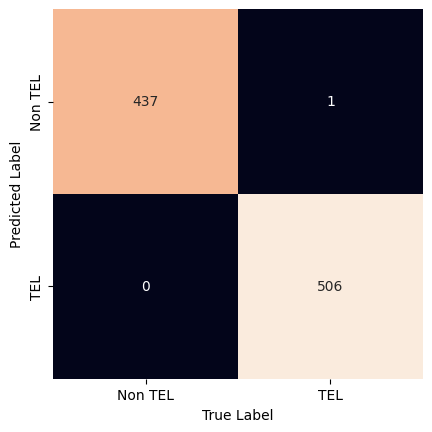

In [15]:
# Print the confusion matrix.

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_pred_class)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['Non TEL', 'TEL'], yticklabels=['Non TEL', 'TEL'])
plt.xlabel('True Label')
plt.ylabel('Predicted Label')

metrics.confusion_matrix(y_test, y_pred_class)

In [16]:
# Print the classification report.

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       437
           1       1.00      1.00      1.00       507

    accuracy                           1.00       944
   macro avg       1.00      1.00      1.00       944
weighted avg       1.00      1.00      1.00       944



In [17]:
# Show the predicted probabilities for the X_test_dtm (non-toxic class).

y_pred_prob_non_tel_class = mnb.predict_proba(X_test_dtm)[:, 0]
y_pred_prob_non_tel_class

array([2.93158634e-16, 1.98655975e-13, 3.92814196e-06, 2.57828781e-15,
       1.00000000e+00, 4.40797535e-13, 9.99999999e-01, 1.00000000e+00,
       1.32767033e-12, 2.35904534e-10, 3.21390086e-20, 6.41963035e-09,
       1.00000000e+00, 3.84699437e-14, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 6.31387033e-17, 2.52605165e-12,
       1.00000000e+00, 9.99999972e-01, 1.00000000e+00, 1.00000000e+00,
       3.87326946e-10, 9.99998877e-01, 1.00000000e+00, 1.00000000e+00,
       7.41977689e-02, 7.21718465e-03, 1.17672133e-14, 9.99962154e-01,
       5.78893409e-20, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.28466415e-14, 2.49866761e-07, 1.00000000e+00, 9.99999029e-01,
       3.69713902e-09, 1.00000000e+00, 1.00000000e+00, 9.99999994e-01,
       2.23095522e-14, 1.00000000e+00, 3.64503762e-16, 1.00000000e+00,
       5.34507411e-11, 4.45266219e-12, 6.35528809e-10, 7.01029588e-16,
       1.00000000e+00, 3.58435603e-12, 1.00000000e+00, 1.00000000e+00,
      

In [18]:
y_pred_prob_tel_class = mnb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob_tel_class

array([1.00000000e+00, 1.00000000e+00, 9.99996072e-01, 1.00000000e+00,
       2.92162698e-47, 1.00000000e+00, 1.35474438e-09, 6.99524736e-39,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 9.99999994e-01,
       1.73927834e-23, 1.00000000e+00, 2.06379407e-17, 1.42321285e-12,
       2.82744020e-10, 1.22742763e-12, 1.00000000e+00, 1.00000000e+00,
       1.55665249e-15, 2.78455961e-08, 1.89547971e-14, 3.45208476e-12,
       1.00000000e+00, 1.12270713e-06, 6.41270775e-11, 1.01057253e-19,
       9.25802231e-01, 9.92782815e-01, 1.00000000e+00, 3.78457489e-05,
       1.00000000e+00, 9.16149408e-18, 9.44395732e-40, 4.48136329e-10,
       1.00000000e+00, 9.99999750e-01, 1.78067716e-11, 9.70903983e-07,
       9.99999996e-01, 8.53767322e-26, 2.23484463e-18, 5.92150865e-09,
       1.00000000e+00, 1.29908645e-15, 1.00000000e+00, 4.66512731e-15,
       1.00000000e+00, 1.00000000e+00, 9.99999999e-01, 1.00000000e+00,
       3.59438007e-26, 1.00000000e+00, 1.23570055e-12, 1.20932229e-21,
      

In [19]:
# Build a data frame with the input text, actual class, predicted class, and the predicted probabilities.

test_results_df = pd.DataFrame({'text': X_test, 'actual': y_test, 'predicted': y_pred_class, 'prob_non_tel': y_pred_prob_non_tel_class, 'prob_tel': y_pred_prob_tel_class})

# Reset the index.
test_results_df.reset_index(drop=True, inplace=True)

test_results_df

,text,actual,predicted,prob_non_tel,prob_tel
0,I'm going to make you the hero of a video game...,1,1,2.931586e-16,1.000000e+00
1,"You think you're clever, hiding your assets of...",1,1,1.986560e-13,1.000000e+00
2,I am the storm that has been gathering on the ...,1,1,3.928142e-06,9.999961e-01
3,The next time your frat party keeps me up all ...,1,1,2.578288e-15,1.000000e+00
4,"Your dedication to [mention a value, e.g., ""so...",0,0,1.000000e+00,2.921627e-47
...,...,...,...,...,...
939,"That spark of an idea you have? Nurture it, fe...",0,0,1.000000e+00,1.021351e-08
940,"My love for you is a vast, ancient river, flow...",0,0,1.000000e+00,9.279244e-15
941,"I am your unshakeable ally, your confidant, an...",0,0,1.000000e+00,1.943985e-15
942,I am so proud of your resilience and how you a...,0,0,1.000000e+00,4.248221e-14


# 3 | Hypertuning the parameters.

## Making a custom stop words.

In [20]:
# Built-in English stop words.
english_stop_words = list(CountVectorizer(stop_words='english').get_stop_words())
custom_stop_words = english_stop_words


## Search for the optimal parameters.

In [21]:
# Hyperparameter tuning using GridSearchCV.

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Create a pipeline with CountVectorizer and MultinomialNB.
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

# Create a dictionary of parameters to search.
params = {
    'cvec__stop_words': [custom_stop_words],
    'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'cvec__min_df': [1, 2, 3, 4],
    'cvec__max_df': [0.01, 0.1, 0.2, 0.3],
    'mnb__alpha': [0.01, 0.1, 1.0, 10.0],
}

# Instantiate GridSearchCV.
gs = GridSearchCV(pipe, param_grid=params, cv=5, verbose=2, n_jobs=-1, scoring='accuracy', refit=True)

# Fit GridSearch to training data.
gs.fit(X_train, y_train)
gs.best_params_

Fitting 5 folds for each of 192 candidates, totalling 960 fits


/Users/marc.viernes/.pyenv/versions/3.13.3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/marc.viernes/.pyenv/versions/3.13.3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/marc.viernes/.pyenv/versions/3.13.3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025

[CV] END cvec__max_df=0.01, cvec__min_df=1, cvec__ngram_range=(1, 1), cvec__stop_words=['afterwards', 'that', 'there', 'beforehand', 'bottom', 'only', 'sincere', 'somewhere', 'serious', 'anything', 'upon', 'sixty', 'empty', 'thence', 'about', 'namely', 'enough', 'but', 'top', 'of', 'seems', 'well', 'further', 'alone', 'any', 'whereafter', 'con', 'ever', 'former', 'also', 'except', 'see', 'yourself', 'indeed', 'was', 'from', 'whom', 'call', 'everyone', 'among', 'here', 'how', 'noone', 'beside', 'show', 'cant', 'out', 'these', 'wherever', 'be', 'amongst', 'un', 'thereby', 'whenever', 'hereupon', 'two', 'been', 'de', 'his', 'above', 'herein', 'wherein', 'no', 'whoever', 'therefore', 'others', 'myself', 'have', 'ours', 'itself', 're', 'take', 'nor', 'already', 'toward', 'nowhere', 'made', 'since', 'interest', 'more', 'several', 'else', 'forty', 'fire', 'would', 'otherwise', 'hasnt', 'many', 'across', 'must', 'after', 'whole', 'something', 'latterly', 'amoungst', 'nobody', 'their', 'often',

{'cvec__max_df': 0.2,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 3),
 'cvec__stop_words': ['afterwards',
  'that',
  'there',
  'beforehand',
  'bottom',
  'only',
  'sincere',
  'somewhere',
  'serious',
  'anything',
  'upon',
  'sixty',
  'empty',
  'thence',
  'about',
  'namely',
  'enough',
  'but',
  'top',
  'of',
  'seems',
  'well',
  'further',
  'alone',
  'any',
  'whereafter',
  'con',
  'ever',
  'former',
  'also',
  'except',
  'see',
  'yourself',
  'indeed',
  'was',
  'from',
  'whom',
  'call',
  'everyone',
  'among',
  'here',
  'how',
  'noone',
  'beside',
  'show',
  'cant',
  'out',
  'these',
  'wherever',
  'be',
  'amongst',
  'un',
  'thereby',
  'whenever',
  'hereupon',
  'two',
  'been',
  'de',
  'his',
  'above',
  'herein',
  'wherein',
  'no',
  'whoever',
  'therefore',
  'others',
  'myself',
  'have',
  'ours',
  'itself',
  're',
  'take',
  'nor',
  'already',
  'toward',
  'nowhere',
  'made',
  'since',
  'interest',
  'more',
  'several'

# 4 | Using the new parameters.

## Building the model.

In [22]:
# Build a new model using the best parameters.

cvect = CountVectorizer(stop_words=custom_stop_words, ngram_range=(1, 3), max_df=0.2, min_df=2, lowercase=False, binary=True)
mnb = MultinomialNB(alpha=1.0)

# Vectorize the data.
X_train_dtm = cvect.fit_transform(X_train)
X_test_dtm = cvect.transform(X_test)

# Fit the data to the model.
mnb.fit(X_train_dtm, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


## Evaluating the model.

In [23]:
# Make class predictions for the X_test_dtm. Store it in the y_pred_class variable.
y_pred_class = mnb.predict(X_test_dtm)

In [24]:

metrics.accuracy_score(y_test, y_pred_class)

0.996822033898305

array([[436,   1],
       [  2, 505]])

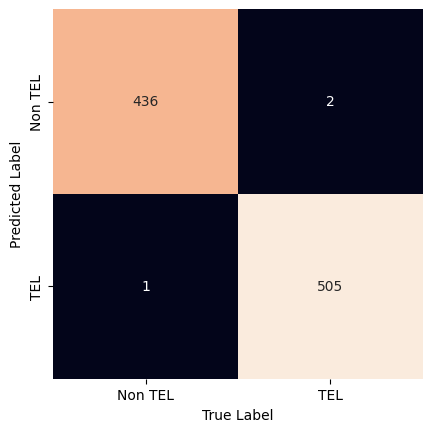

In [25]:
mat = confusion_matrix(y_test, y_pred_class)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['Non TEL', 'TEL'], yticklabels=['Non TEL', 'TEL'])
plt.xlabel('True Label')
plt.ylabel('Predicted Label')

metrics.confusion_matrix(y_test, y_pred_class)

In [26]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       437
           1       1.00      1.00      1.00       507

    accuracy                           1.00       944
   macro avg       1.00      1.00      1.00       944
weighted avg       1.00      1.00      1.00       944



In [27]:
raw = mnb.predict_proba(X_test_dtm)
raw

array([[1.75704295e-18, 1.00000000e+00],
       [4.40684526e-15, 1.00000000e+00],
       [3.42096933e-04, 9.99657903e-01],
       ...,
       [1.00000000e+00, 3.95731995e-13],
       [1.00000000e+00, 4.53475411e-19],
       [2.60604167e-04, 9.99739396e-01]], shape=(944, 2))

In [28]:
# Show the predicted probabilities for the X_test_dtm (non-toxic class).

y_pred_prob_non_tel_class = mnb.predict_proba(X_test_dtm)[:, 0]
y_pred_prob_non_tel_class

array([1.75704295e-18, 4.40684526e-15, 3.42096933e-04, 2.89420808e-17,
       1.00000000e+00, 3.73892599e-13, 1.00000000e+00, 1.00000000e+00,
       4.97689558e-11, 8.29448199e-12, 8.73806290e-18, 1.21687253e-06,
       1.00000000e+00, 1.50927648e-15, 1.00000000e+00, 1.00000000e+00,
       9.99995504e-01, 1.00000000e+00, 1.49770930e-14, 3.74019511e-10,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       2.15398811e-11, 9.99999780e-01, 1.00000000e+00, 1.00000000e+00,
       3.45357695e-07, 5.91762933e-02, 2.60914561e-16, 9.98421156e-01,
       4.45555293e-15, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       5.16683454e-17, 1.29363405e-08, 9.99999999e-01, 9.95950626e-01,
       1.82640939e-08, 1.00000000e+00, 1.00000000e+00, 9.99999997e-01,
       6.69162138e-10, 1.00000000e+00, 6.87134748e-20, 1.00000000e+00,
       4.59587758e-11, 2.81922124e-13, 7.60463345e-20, 1.15828644e-12,
       1.00000000e+00, 1.16870087e-13, 1.00000000e+00, 1.00000000e+00,
      

In [29]:
# Show the predicted probabilities for the X_test_dtm (toxic class).

y_pred_prob_tel_class = mnb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob_tel_class

array([1.00000000e+00, 1.00000000e+00, 9.99657903e-01, 1.00000000e+00,
       2.58906924e-51, 1.00000000e+00, 4.03927322e-12, 5.00319848e-65,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 9.99998783e-01,
       2.37917291e-41, 1.00000000e+00, 1.26853532e-20, 3.54707933e-11,
       4.49629932e-06, 2.29178393e-10, 1.00000000e+00, 1.00000000e+00,
       1.23812574e-14, 2.74032531e-16, 7.73991204e-11, 1.41320392e-11,
       1.00000000e+00, 2.20340724e-07, 3.87351226e-10, 5.77665911e-18,
       9.99999655e-01, 9.40823707e-01, 1.00000000e+00, 1.57884381e-03,
       1.00000000e+00, 1.29078281e-22, 1.72839805e-50, 3.13221787e-11,
       1.00000000e+00, 9.99999987e-01, 7.78579398e-10, 4.04937415e-03,
       9.99999982e-01, 2.61619388e-36, 1.28872137e-19, 3.23961206e-09,
       9.99999999e-01, 3.29392737e-16, 1.00000000e+00, 1.43573103e-22,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.45889610e-36, 1.00000000e+00, 7.35526132e-16, 2.84547809e-26,
      

In [31]:
# Build a data frame with the input text, actual class, predicted class, and the predicted probabilities.

test_results_df = pd.DataFrame({'text': X_test, 'actual': y_test, 'predicted': y_pred_class, 'prob_non_tel': y_pred_prob_non_tel_class, 'prob_tel': y_pred_prob_tel_class})

# Reset the index.
test_results_df.reset_index(drop=True, inplace=True)

test_results_df

,text,actual,predicted,prob_non_tel,prob_tel
0,I'm going to make you the hero of a video game...,1,1,1.757043e-18,1.000000e+00
1,"You think you're clever, hiding your assets of...",1,1,4.406845e-15,1.000000e+00
2,I am the storm that has been gathering on the ...,1,1,3.420969e-04,9.996579e-01
3,The next time your frat party keeps me up all ...,1,1,2.894208e-17,1.000000e+00
4,"Your dedication to [mention a value, e.g., ""so...",0,0,1.000000e+00,2.589069e-51
...,...,...,...,...,...
939,"That spark of an idea you have? Nurture it, fe...",0,0,1.000000e+00,1.951438e-10
940,"My love for you is a vast, ancient river, flow...",0,0,1.000000e+00,1.135943e-14
941,"I am your unshakeable ally, your confidant, an...",0,0,1.000000e+00,3.957320e-13
942,I am so proud of your resilience and how you a...,0,0,1.000000e+00,4.534754e-19


# 5 | Using Other AI Model (for comparison)

In [32]:
df

,text,label
0,"I will find you, and I will make you a part of...",1
1,"I would gather all the morning dewdrops, each ...",0
2,I know you're pregnant. Congratulations. But i...,1
3,You think you can get away with what you did t...,1
4,I'm going to make you feel the cold hand of de...,1
...,...,...
3768,The child you're carrying is an abomination. I...,1
3769,"I will walk beside you through this fire, offe...",0
3770,Your willingness to be open and share your tru...,0
3771,You think you can just hack my account and not...,1


## 5.1 | K-Means using 2 clusters.

The K-means models will use the X_train_dtm as its training set. The K-means algorithm aims to label unlabeled data, which in this case, the labeled training set will be considered unlabeled data. This data will then be compared to the actual labeled values in the y_train set, hence the increase in the number of test values when compared to the test values of the MNB models.

Increasing the unlabeled data to contain the entire dataset results to a negligible difference in accuracy rate but a significant increase in runtime, hence only the test dataset, which contains 80% of the dataset, is used.

In [33]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_train_dtm)
kmeans.cluster_centers_.shape

(2, 14091)

In [34]:
import numpy as np
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask], keepdims=True)[0]

### Check for accuracy.

In [35]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, labels)

0.601272534464475

Text(113.9222222222222, 0.5, 'Predicted label')

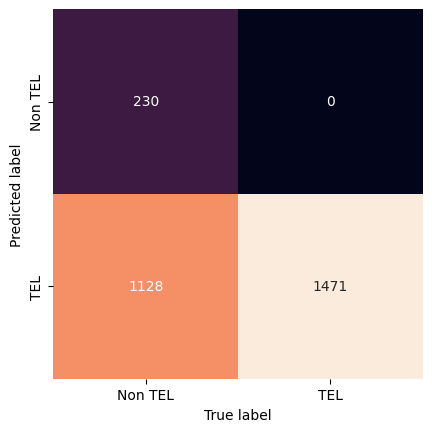

In [36]:
mat = confusion_matrix(y_train, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
             xticklabels=['Non TEL', 'TEL'], yticklabels=['Non TEL', 'TEL'])
plt.xlabel('True label')
plt.ylabel('Predicted label')

## 5.2 | K-Means using 2 clusters with t-SNE.

In [37]:
from sklearn.manifold import TSNE

# Using t-SNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=69)
projection = tsne.fit_transform(X_train_dtm)

# Compute the clusters
kmeans = KMeans(n_clusters=2, n_init=10, random_state=69)
clusters = kmeans.fit_predict(projection)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask], keepdims=True)[0]

### Check for accuracy.

In [38]:
accuracy_score(y_train, labels)

0.519971721456345

Text(113.9222222222222, 0.5, 'Predicted label')

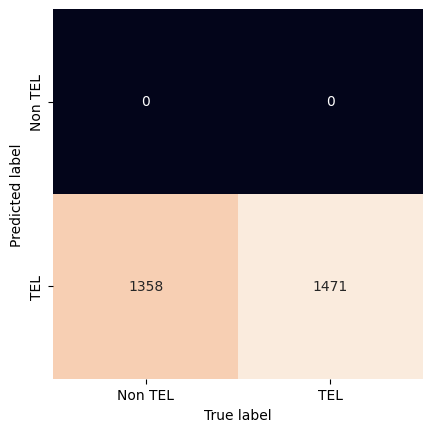

In [39]:
mat = confusion_matrix(y_train, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
             xticklabels=['Non TEL', 'TEL'], yticklabels=['Non TEL', 'TEL'])
plt.xlabel('True label')
plt.ylabel('Predicted label')

## 5.3 | Try 1-10 clusters while using t-SNE.

In [40]:
kmeans = []
accuracy_scores = []
inertias = []

for i in range(1, 11):
    # Project the data: this step will take several seconds
    temp_tsne = TSNE(n_components=2, init='random', random_state=69)
    temp_projection = temp_tsne.fit_transform(X_train_dtm)

    # Compute the clusters
    temp_kmeans = KMeans(n_clusters=i, n_init=10, random_state=69)
    temp_clusters = temp_kmeans.fit_predict(temp_projection)
    kmeans.append(temp_kmeans)

    # Permute the labels
    temp_labels = np.zeros_like(temp_clusters)
    for j in range(2):
        mask = (temp_clusters == j)
        temp_labels[mask] = mode(y_train[mask], keepdims=True)[0]

    # Compute the accuracy
    temp_accuracy_score = accuracy_score(y_train, temp_labels)
    accuracy_scores.append(temp_accuracy_score)

    # Get the inertia
    temp_inertia = temp_kmeans.inertia_
    inertias.append(temp_inertia)


/var/folders/kf/ky7qspm53s1czj0m691v57ssx4_wph/T/ipykernel_43117/2496906184.py:19: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  temp_labels[mask] = mode(y_train[mask], keepdims=True)[0]


### Determine the best cluster size.

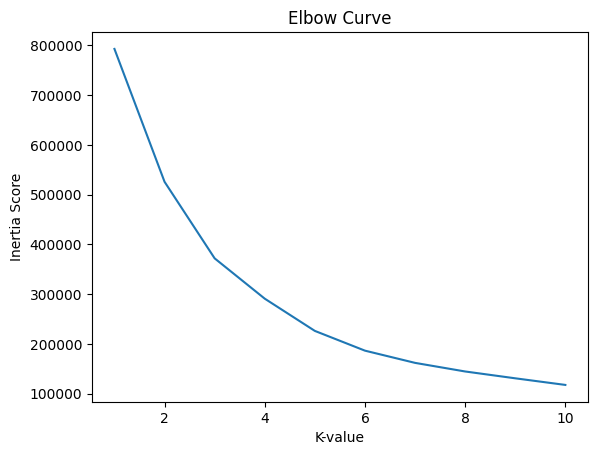

In [41]:
# Display the Elbow Curve graph.

plt.plot(range(1, 11), inertias)
plt.xlabel('K-value')
plt.ylabel('Inertia Score')
plt.title('Elbow Curve')
plt.show()

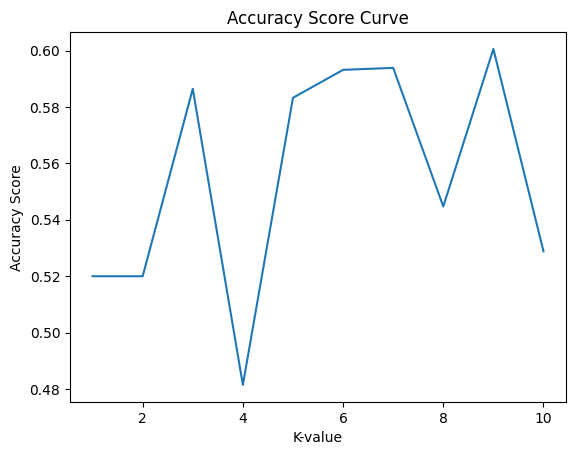

In [42]:
# Display the Accuracy Score Curve graph.

plt.plot(range(1, 11), accuracy_scores)
plt.xlabel('K-value')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score Curve')
plt.show()

In [43]:
# Construct a data frame with the K-value and the corresponding accuracy score.

kmeans_accuracy_df = pd.DataFrame({'k': range(1, 11), 'accuracy_score': accuracy_scores})
kmeans_accuracy_df

,k,accuracy_score
0,1,0.519972
1,2,0.519972
2,3,0.586426
3,4,0.481442
4,5,0.583245
5,6,0.593142
6,7,0.593849
7,8,0.544715
8,9,0.600566
9,10,0.528809


# 7 | Some Results Showcase